Introduction 
===

In this notebook we will demonstrate two methods of 

### 1. Willmore Energy Flow:

The Willmore energy is defined by: 

$$
E=\int_{M} H^{2} d A
$$

The discrete Willmore energy is defined by:

$$
E_{\text {discrete }}=\sum_{i \in V}(H N)_{i}^{2} / A_{i}
$$

Noting that
$$
\nabla E_{W}(f) = \frac{1}{4}\langle\langle\Delta f, \Delta f\rangle\rangle=\frac{1}{4}\left\langle\left\langle\Delta^{2} f, f\right\rangle\right\rangle
$$

$$
\dot{f} = -\nabla E_{W}(f) =-\frac{1}{2} \Delta^{2} f
$$

##### NOTE: This should be $C_{i}$ and not $A_{i}$? I believe this is a typo in the notes. Read the papers again.
##### NOTE 2: Why do we only devide by $C_{i}$  once; $H N)_{i}$ is the integrated mean curvature over a vertex neighbourhood, so $(H N)_{i}^{2}$ contains a factor of squared area and we cancel one of those factors out. Remember that we want to integrate mean curvature squared over the whole surface.

The change in time is defined by:
$$
\frac{d}{d t}= -\nabla_{f} E
$$


### 2. Mean Curvature Flow:

Energy defined by:
$$
E(f)=\int_{M} d A
$$

Differential energy by:
$$
\delta E=2 H N d A
$$

Surface change over time:
$$
\frac{d}{d t} f=-2 H N
$$

Discretised differential:

$$
f_{i}^{k+1}=f_{i}^{k}-\frac{\tau}{2} \sum_{i j \in \operatorname{St}(i)}\left(\cot \alpha_{i j}+\cot \beta_{i j}\right)\left(f_{j}^{k}-f_{i}^{k}\right)
$$

### 3. Gauss Energy Flow (TODO):

Energy defined by:
$$
E(f)=\int_{M} H d A
$$

Differential energy by:
$$
\delta E=K N d A
$$

Surface change over time:
$$
\frac{d}{d t} f=-K N
$$

Discretised differential:

$$
f_{i}^{k+1}=f_{i}^{k}-\frac{\tau}{2} \sum_{i j \in \mathrm{St}(i)} \frac{\varphi_{i j}}{\ell_{i j}}\left(f_{j}^{k}-f_{i}^{k}\right)
$$

In [6]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
%matplotlib notebook

# Parameters for a water droplet in air at standard laboratory conditions
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

from ddgclib import *
from hyperct import Complex
#from ddgclib.curvatures import plot_surface, curvature

# Colour scheme for surfaces
db = np.array([129, 160, 189]) / 255  # Dark blue
lb = np.array([176, 206, 234]) / 255  # Light blue

def willmore_flow(HC, tau=0.5):
    """
    Compute a single iteration of Willmore curvature flow
    :param HC: Simplicial complex
    :return:
    """
    # Define the normals (NOTE: ONLY WORKS FOR CONVEX SURFACES)
    # Note that the cache HC.V is an OrderedDict:
    N_i = []

    for v in HC.V:
        N_i.append(normalized(v.x_a - np.array([0.5, 0.5, 0.5]))[0])

    f = []
    W = []
    for i, v in enumerate(HC.V):
        F, nn = vectorise_vnn(v)
        c_outd = curvatures(F, nn, n_i=N_i[i])
        W.append(np.linalg.norm(c_outd['HNdA_i'])/c_outd['C_ijk'])
        f.append(v.x_a)

    df = np.nan_to_num(np.array(W))
    f = np.array(f)
    tau = 0.5
    f_k = f + tau * df
    VA = []
    for v in HC.V:
        VA.append(v.x_a)

    VA = np.array(VA)
    for i, v_a in enumerate(VA):
        HC.V.move(HC.V[tuple(v_a)], tuple(f_k[i]))

    return HC

def mean_flow(HC, tau=0.5):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :return:
    """
    # Define the normals (NOTE: ONLY WORKS FOR CONVEX SURFACES)
    # Note that the cache HC.V is an OrderedDict:
    N_i = []

    for v in HC.V:
        N_i.append(normalized(v.x_a - np.array([0.5, 0.5, 0.5]))[0])

    f = []
    HNdA = []
    for i, v in enumerate(HC.V):
        F, nn = vectorise_vnn(v)
        c_outd = curvatures(F, nn, n_i=N_i[i])
       # HNdA.append(0.5*c_outd['HNdA_i'])
        #print(np.sum(c_outd['H_ij_sum']))
        #print(np.sum(c_outd['C_ijk']))
        #HNdA.append(np.sum(c_outd['H_ij_sum'])/np.sum(c_outd['C_ijk']))
        HNdA.append(N_i[i] * np.sum(c_outd['H_ij_sum'])/np.sum(c_outd['C_ijk']))
        f.append(v.x_a)

    pass
    #print(f'HNdA = { HNdA}')
    #print(f"(np.sum(c_outd['H_ij_sum'])/np.sum(c_outd['C_ijk']))  = {(np.sum(c_outd['H_ij_sum'])/np.sum(c_outd['C_ijk']))}")
    df = np.nan_to_num(np.array(HNdA))
    f = np.array(f)
    f_k = f - tau * df
    VA = []
    for v in HC.V:
        VA.append(v.x_a)

    VA = np.array(VA)
    for i, v_a in enumerate(VA):
        HC.V.move(HC.V[tuple(v_a)], tuple(f_k[i]))

    if 0:
        HCV2 = list(copy.copy(HC.V))
        for i, v in enumerate(HCV2):
            HC.V.move(v, tuple(f_k[i]))

    return HC



In [7]:
# Droplet parameters
R = 1.0  # Radius of the droplet sphere
H_f = 1/R + 1/R
K_f = (1/R)**2

theta = 0
phi = 0.0

<IPython.core.display.Javascript object>


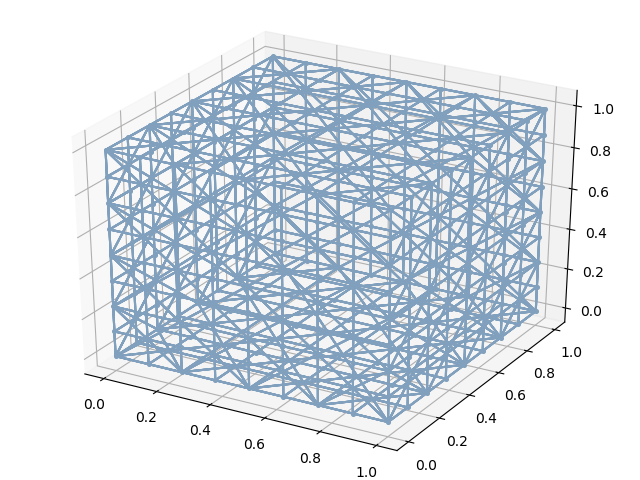

In [8]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(3):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

In [9]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(2):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(1):
    HC = willmore_flow(HC, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


ValueError: operands could not be broadcast together with shapes (98,3) (98,) 

<IPython.core.display.Javascript object>


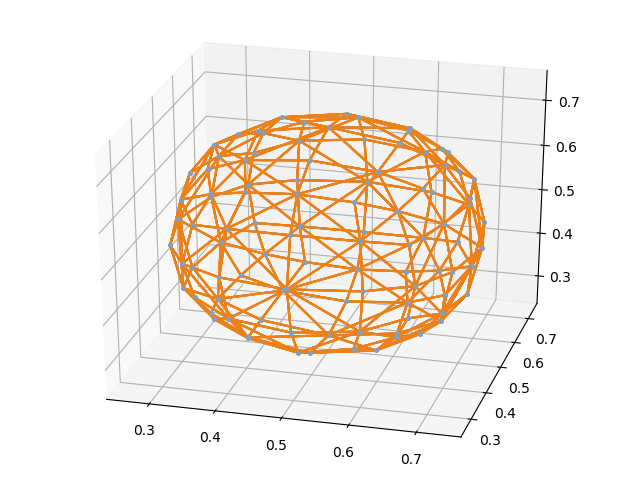

In [10]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(2):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(100):
    HC = mean_flow(HC, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           
                                           complex_color_e=db
                                           )

<IPython.core.display.Javascript object>


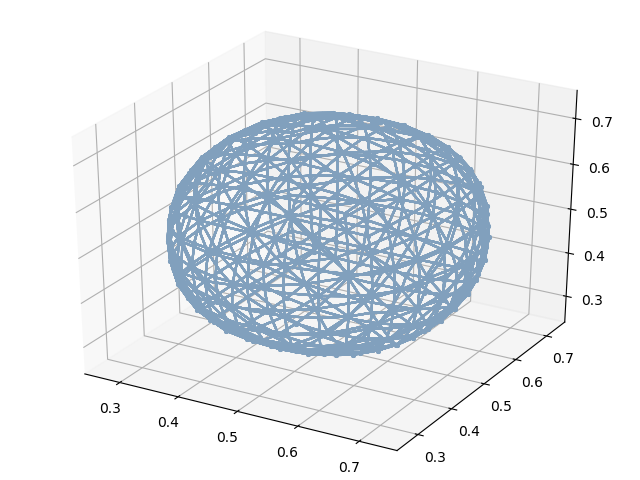

In [11]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(3):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(100):
    HC = mean_flow(HC, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           
                                           complex_color_e=db
                                           )

C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_curvatures.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / np.tan(theta)
C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_curvatures.py:222: RuntimeWarning: invalid value encountered in multiply
  HNdA_ij[j] = (cotan(alpha_ij) + cotan(beta_ij)) * (F[j] - F[i])
C:\Users\Endres\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_curvatures.py:210: RuntimeWarning: invalid value encountered in arccos
  alpha_ij = np.arccos((a ** 2 + b ** 2 - c ** 2) / (2 * a * b))


<IPython.core.display.Javascript object>


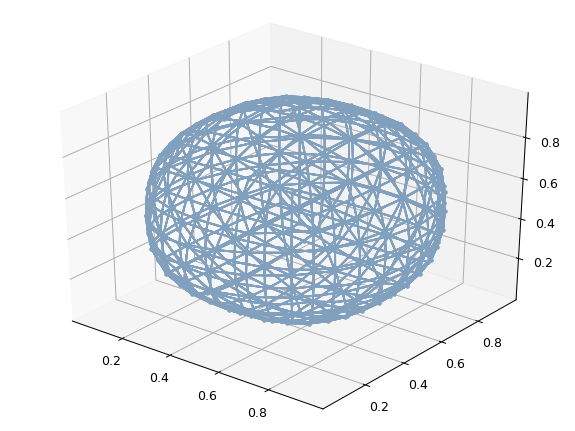

In [25]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(3):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(50):
    HC = mean_flow(HC, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           
                                           complex_color_e=db
                                           )

<IPython.core.display.Javascript object>


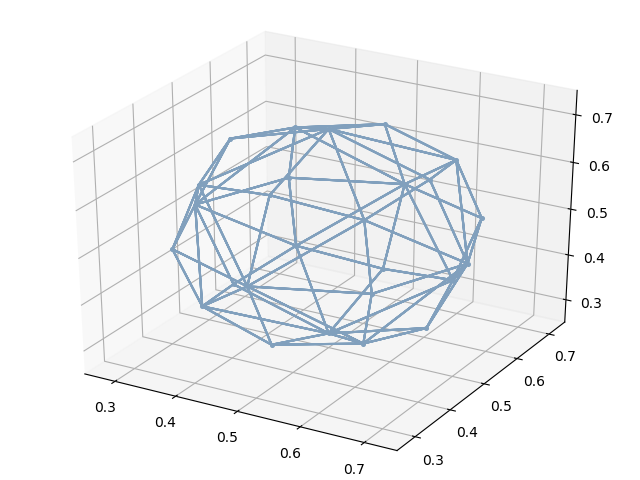

In [16]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(1):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(100):
    HC = mean_flow(HC, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           
                                           complex_color_e=db
                                           )

Gauss Bonnet
==

In [64]:
def chi_H(HC, print_out=True):
    """
    Compute the 2D Euler Characterisitc
    """
    ## Computer Euler Characteristic:
    # Compute the number of vertices
    V = len(list(HC.V))
    # Compute the dges
    E = 0
    for v in HC.V:
        E += len(list(v.nn))
        
    E = E/2.0 # We have added precisely twice the number of edges through adding each connection
    # Compute the faces
    HC.dim = 2  # We have taken the boundary of the sphere
    HC.vertex_face_mesh()
    Faces = HC.simplices_fm
    F = len(Faces)
    
    # Compute Euler
    chi = V - E + F
    if print_out:
        print(f'V = {V}')
        print(f'E = {E}')
        print(f'F = {F}')
        print(f'$\chi = V - E + F$ = {chi}')   
        
    return chi

def K_t(HC, bV=set()):
    """
    Compute the integrated Gaussian curvature on the surface 
    """
    KdA = 0.0
    for v in HC.V:
        if v in bV:
            continue
        else:
            N_f0 = v.x_a - np.zeros_like(v.x_a)  # First approximation # TODO: CHANGE FOR CAP RISE!
            F, nn = vectorise_vnn(v)
            # Compute discrete curvatures
            c_outd = curvatures(F, nn, n_i=N_f0)
            KdA += c_outd['Omega_i']  # == c_outd['K']
            
    return KdA
    
def k_g_t(HC, bV):
    k_g = 0
    for v in bV:
        Theta_i_jk = 0.0
        Simplices = set()
        Dual = set()
        for vn in v.nn:
            if vn in Dual:
                continue
            for vnn in vn.nn:
                if vnn in v.nn:  # Add edges connected to v_i
                    E_ij = vn.x_a - v.x_a
                    E_ik = vnn.x_a - v.x_a
                    
                    # Discrete vector area:
                    # Simplex areas of ijk and normals
                    wedge_ij_ik = np.cross(E_ij, E_ik)

                    #Wedge_ij_ik[j] = wedge_ij_ik
                    theta_i_jk = np.arctan2(np.linalg.norm(wedge_ij_ik), np.dot(E_ij, E_ik))
                    Theta_i_jk += theta_i_jk
                    Dual.add(vnn)

        k_g += np.pi - Theta_i_jk
        
    return k_g

def Gauss_Bonnet(HC, bV=set()):
    """
    Compute a single iteration of mean curvature flow
    :param HC: Simplicial complex
    :return:
    """
    chi = chi_H(HC)
    KdA = K_t(HC, bV)
    k_g = k_g_t(HC, bV)
    print(f' KdA = {KdA}')
    print(f' k_g = {k_g}')
    print(f' 2 pi chi$ = {2 * np.pi * chi}')
    print(f' LHS - RHS = {KdA + k_g - 2 * np.pi * chi}')
    return chi, KdA

Gauss_Bonnet(HC)

V = 26
E = 72.0
F = 48
$\chi = V - E + F$ = 2.0
 KdA = 12.566370614359169
 k_g = 0
 2 pi chi$ = 12.566370614359172
 LHS - RHS = -3.552713678800501e-15


(2.0, 12.566370614359169)

<IPython.core.display.Javascript object>


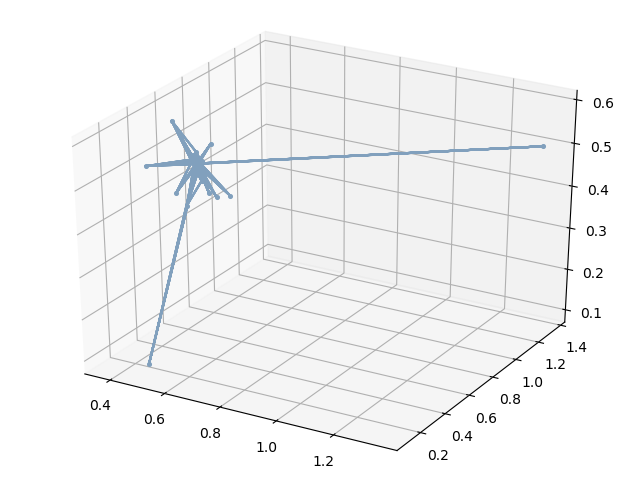

In [66]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(1):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(1000):
    HC = mean_flow(HC, tau=0.001)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           
                                           complex_color_e=db
                                           )

C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_curvatures.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / np.tan(theta)
C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_curvatures.py:222: RuntimeWarning: invalid value encountered in multiply
  HNdA_ij[j] = (cotan(alpha_ij) + cotan(beta_ij)) * (F[j] - F[i])
C:\Users\Endres\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_curvatures.py:210: RuntimeWarning: invalid value encountered in arccos
  alpha_ij = np.arccos((a ** 2 + b ** 2 - c ** 2) / (2 * a * b))
C:\Users\Endres\Desktop\iwt-projects\ddg\ddgclib\_curvatures.py:213: RuntimeWarning: invalid value encountered in arccos
  beta_ij = np.arccos((a ** 2 + b ** 2 - c ** 2) / (2 * a * b))


<IPython.core.display.Javascript object>


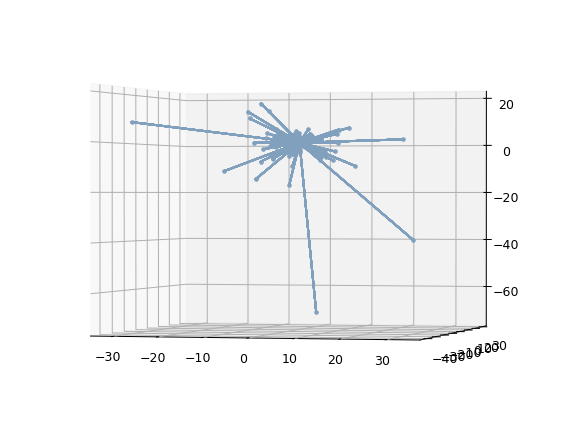

In [18]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(3):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(2000):
    HC = mean_flow(HC, tau=0.1)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

In [ ]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(2):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(5000):
    HC = mean_flow(HC, tau=0.01)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

In [ ]:
for v in HC.V:
    N_i.append(normalized(v.x_a - np.array([0.5, 0.5, 0.5]))[0])
    
N_i

In [ ]:
f = []
HNdA = []
for i, v in enumerate(HC.V):
    F, nn = vectorise_vnn(v)
    c_outd = curvatures(F, nn, n_i=N_i[i])
    HNdA.append(c_outd['HNdA_i'])
    f.append(v.x_a)

df = np.nan_to_num(np.array(HNdA))
f = np.array(f)
tau = 0.5
f_k = f + tau * df
VA = []
for v in HC.V:
    VA.append(v.x_a)

In [ ]:
c_outd.keys()

In [ ]:
df

In [ ]:
HNdA

In [ ]:
# Initiate a cubical complex
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(2):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)
    
for i in range(2):
    HC = mean_flow(HC, tau=0.5)
    
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )

In [ ]:
HC = Complex(3)
HC.triangulate()
#vc = HC.V[(0.5, 0.5, 0.5)]
#HC.V.remove(vc)

for i in range(2):
    HC.refine_all()

#for v in HC2V:
#    HC.refine_star(v)
del_list = []
for v in HC.V:
    if np.any(v.x_a == 0.0) or np.any(v.x_a == 1.0):
        continue
    else:
        del_list.append(v)

for v in del_list:
    HC.V.remove(v)

In [ ]:
# Define the normals (NOTE: ONLY WORKS FOR CONVEX SURFACES)
# Note that the cache HC.V is an OrderedDict:
N_i = []
for v in HC.V:
    N_i.append(normalized(v.x_a - np.array([0.5, 0.5, 0.5]))[0])

In [ ]:
help(curvatures)

In [ ]:
f = []
HNdA = []
for i, v in enumerate(HC.V):
    F, nn = vectorise_vnn(v)
    c_outd = curvatures(F, nn, n_i=N_i[ind])
    HNdA.append(c_outd['HNdA_i'])
    f.append(v.x_a)

In [ ]:
df = np.nan_to_num(np.array(HNdA))
f = np.array(f)

In [ ]:
tau = 0.5 
f_k = f + tau * df


In [ ]:
VA = []
for v in HC.V:
    VA.append(v.x_a)
    
VA = np.array(VA)

In [ ]:
for v in HC.V:
    print(v.nn)

In [ ]:
for i, v_a in enumerate(VA):
    HC.V.move(HC.V[tuple(v_a)], tuple(f_k[i]))

In [ ]:
for v in HC.V:
    print(v.nn)

In [ ]:
HCV2 = list(copy.copy(HC.V))
for i, v in enumerate(HCV2):
    HC.V.move(v, tuple(f_k[i]))
    

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure(1)
fig, axes, fig_s, axes_s = HC.plot_complex(point_color=db,
                                           line_color=db,
                                           complex_color_f=lb,
                                           complex_color_e=db
                                           )


In [ ]:
c_outd.keys()

In [ ]:
for v in HC.V:
    print(len(v.nn))